#MobileNet

MobileNet is a family of lightweight convolutional neural network architectures designed for mobile and embedded devices. It focuses on achieving good accuracy while maintaining low computational cost and memory footprint. For its weight it was chosen before using other famous architectures such as ResNet or VGG.

Keras offers two main options for using MobileNet in deep learning projects:

1. Pre-trained MobileNet weights: the model weights were pre-trained using ImageNet dataset, which consists of over 14 million images, categorized into 1000 distinct classes. These classes encompass a wide range of objects, from everyday items like animals and objects. This provides good starting point for transfer learning and fine-tuning for custom models, such as CIFAR100 and other classification tasks. 
2. Base model: allows to build the model from scratch using MobileNet architecture.



In [2]:
import keras as keras
from keras.datasets import cifar100
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.applications import MobileNet

#Model evaluation

In [40]:
mobilenet = MobileNet(weights='imagenet')#, input_shape = (224,224,3))

In [4]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [33]:
resize = Resizing(224,224)
image = resize(x_train[0])
x = tf.cast(image, tf.int32)
# reshape data for the model
# prepare the image for the MobileNet model
image = preprocess_input(image)
image = np.reshape(image,[1,224,224,3])
# predict the probability across all output classes
yhat = mobilenet.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)[0]
# retrieve the most likely result, e.g. highest probability
print(label)

1/1 [==============================] - 0s 56ms/step
[('n02091635', 'otterhound', 0.14504214), ('n02109047', 'Great_Dane', 0.12552543), ('n03764736', 'milk_can', 0.057403665), ('n04604644', 'worm_fence', 0.04428871), ('n02090379', 'redbone', 0.040960398)]


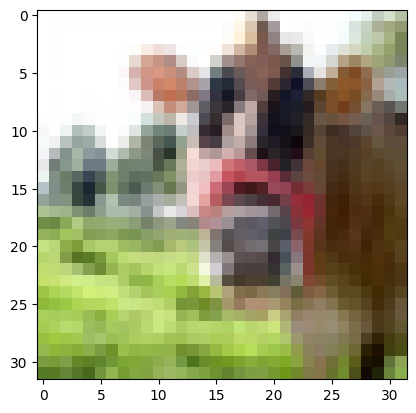

In [34]:
plt.imshow(x_train[0])

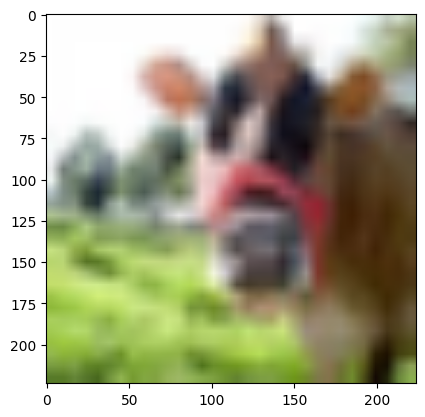

In [35]:
plt.imshow(x)

From the results we can see that it miss-classifies the image as 'otterhound' despite beeing actually a 'cow'. This can be possible due to the low resolution input image, which results in loss of information. The CIFAR100 dataset consits of 32x32  pixels images and the model was trained using 224x224 inputs.

Now we will see how the model performs using an image extracted from internet.

1/1 [==============================] - 0s 56ms/step
[[('n02106662', 'German_shepherd', 0.74917597), ('n02105162', 'malinois', 0.24877036), ('n02111129', 'Leonberg', 0.0012773436), ('n02091467', 'Norwegian_elkhound', 0.00013495934), ('n02114712', 'red_wolf', 0.00013126295)]]


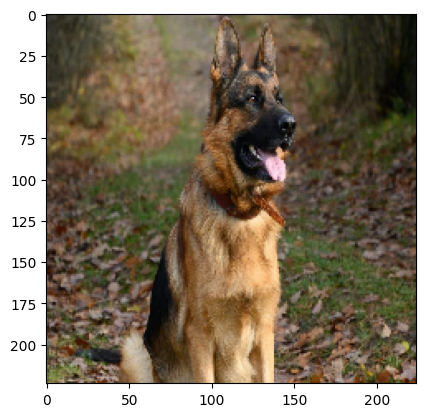

In [50]:
import urllib.request
from keras.preprocessing import image

# Public domain image
url = 'https://gabrielmoon.ca/wp-content/uploads/2021/09/master-loves-you-scaled-e1631284978924-1024x766.jpg'
urllib.request.urlretrieve(url, 'car.jpg')

# Load image and resize (doesn't keep aspect ratio)
img = image.load_img('car.jpg', target_size=(224, 224))
plt.imshow(img)
# Turn to array of shape (224, 224, 3)
img = image.img_to_array(img)
# Expand array into (1, 224, 224, 3)
img = np.expand_dims(img, 0)
# Preprocess for models that have specific preprocess_input() function
img_preprocessed = preprocess_input(img)

# Load model and run prediction
pred = mobilenet.predict(img)
print(decode_predictions(pred))

#Transfer Learning

Transfer learning is a powerful technique in machine learning that leverages the knowledge gained from one task to improve performance on a different but related task. In the context of deep learning, it involves using a pre-trained model on a large dataset like ImageNet and adapting it to a new task with less data, such as CIFAR100. 

So, instead of begining the training process from scratch, which is time-consuming and requires significant data and computational resources, you could use a pre-trained model like MobileNet, which has already learned low-level features like edges, textures, and shapes from millions of images on ImageNet. Then you can "cut off" the top layers (responsible for ImageNet classification) and replace them with new layers specific to the task requiered. These new layers would learn the higher-level features that distinguish different classes needed. This can lead to faster training, improved performance. 

In this case we will use MobileNet pre-trained model on ImageNet to solve the CIFAR100 classification task. 










In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/My Drive/Colab Notebooks/CNN/CNN_CIFAR100_Classifier/notebooks
%pwd
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/My Drive/Colab Notebooks/CNN/CNN_CIFAR100_Classifier/notebooks'
/content/drive/My Drive/Colab Notebooks/CNN/CNN_CIFAR100_Classifier/notebooks
CIFAR10_CLASSIFIER_LENET.ipynb  make_dataset.py         mobilenet.ipynb
Data_Analysis.ipynb             mobilenet_2_lrp_0.5.h5  MobileNet_Transfer_Learning.ipynb
logs.csv                        mobilenet.h5            Untitled0.ipynb


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Resizing, Rescaling
from keras import optimizers
import keras.utils
import numpy as np
from keras.applications import MobileNet
from keras.callbacks import  ReduceLROnPlateau, CSVLogger
from src.data.make_dataset import load_data

To use this model it is important to consider: 
1. Input shape: MobileNet expects images with a specific size (typically 224x224x3).Images must be adjusted accordingly.
2. Image preprocessing: Normalize your images before feeding them to the model for optimal performance.

in ````load_data()```` function, ```image_preprocessing``` function is called and applies transformations to the image, the same transfromations that were used on the original dataset, this includes standarizations and other technics. It also represents the lables in one-hot encoding.

In [4]:
(x_train, y_train), (x_test, y_test) , classes = load_data()

[Info] Loading CIFAR10 dataset ...
169001437/169001437 [==============================] - 2s 0us/step
[Info] Dataset loaded
number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 100)


When the model is load, we einclude the weights from imagenet and exclude the top layer, responsible for the clasification of ImageNet.

In [5]:
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape = (224, 224, 3) , classes=y_train.shape[1])

17225924/17225924 [==============================] - 0s 0us/step


This model consits of a pretty simple architecture. First a resizing and rescaling layers are needed to adjust the 32x32 input format to the format required by the network 224,224 and the reacaling applies normalization. Then the image is passes to the mobilenet network and finally we include a some fully connected layers to classify the image. Also some dropout layers are included for regularization.

In [6]:
model = Sequential([
  Resizing(224,224),
  Rescaling(1./255),
  mobilenet,
  Flatten(),
  Dense(1024,activation=('relu')),
  Dense(512,activation=('relu')),
  Dropout(.3),
  Dense(256,activation=('relu')),
  Dropout(.2),
  Dense(100,activation=('softmax'))
])

In [7]:
model.build((None, 224,224,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='min', patience= 3, factor= 0.5, min_lr= 1e-6, verbose=1)
log_csv = CSVLogger(os.path.join(os.getcwd(), "logs.csv"), separator=",", append=False)

In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test),batch_size = 64, epochs = 10, callbacks = [rlrop,log_csv], verbose = 1)

Epoch 1/10
782/782 [==============================] - 215s 251ms/step - loss: 3.4271 - accuracy: 0.1820 - val_loss: 3.8147 - val_accuracy: 0.1850 - lr: 0.0010
Epoch 2/10
782/782 [==============================] - 204s 261ms/step - loss: 2.1893 - accuracy: 0.4067 - val_loss: 2.1296 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 3/10
782/782 [==============================] - 194s 248ms/step - loss: 1.7526 - accuracy: 0.5205 - val_loss: 1.9834 - val_accuracy: 0.4785 - lr: 0.0010
Epoch 4/10
782/782 [==============================] - ETA: 0s - loss: 1.4872 - accuracy: 0.5876
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 [==============================] - 205s 262ms/step - loss: 1.4872 - accuracy: 0.5876 - val_loss: 2.0102 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 5/10
782/782 [==============================] - 204s 261ms/step - loss: 1.0018 - accuracy: 0.7101 - val_loss: 1.3300 - val_accuracy: 0.6396 - lr: 5.0000e-04
Epoch 6/10
782/782 [====================

In [ ]:
model.save('mobilenet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
